In [1]:
from nets import UNet
from downloads import download_data, unzip_data
from datasets import Cell_Challenge_Segmentation_Dataset
from training import train_UNet, EarlyStopping
from segmentation import post_processing
from visualization import plot_mini_batch

import os

import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
import albumentations as alb

In [2]:
cell_type = 'Fluo-N3DH-CHO'
# cell_type = 'BF-C2DL-MuSC'

download_data(cell_type)
unzip_data(cell_type)

batch_size = 4

tranfor = alb.Compose([
    alb.HorizontalFlip(p=0.5),
    alb.VerticalFlip(p=0.5),
    alb.RandomCrop(400,400)
], additional_targets={'image': 'image', 'mask': 'image'})

Train = Cell_Challenge_Segmentation_Dataset(cell_type, None)
Cell_train, Cell_val = random_split(Train, [0.8, 0.2])

train_loader = DataLoader(Cell_train, batch_size, shuffle=True)
val_loader = DataLoader(Cell_val, batch_size, shuffle=True)

Test = Cell_Challenge_Segmentation_Dataset(cell_type, None, test=True)  # test mode
Test1, Test2 = train_test_split(Test, train_size=0.5, shuffle=False)    # split without shuffling

test_loader1 = DataLoader(Test1, batch_size, shuffle=False)
test_loader2 = DataLoader(Test2, batch_size, shuffle=False)

Fluo-N3DH-CHO training_data data already downloaded
Fluo-N3DH-CHO test_data data already downloaded
Fluo-N3DH-CHO training_data data already unzipped
Fluo-N3DH-CHO test_data data already unzipped


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = UNet(1, 64, 2)
epochs = 15
store_every = 1
optimiser_unet = torch.optim.SGD(model.parameters(),
                                 lr=0.005, momentum=0.95,
                                 weight_decay=1e-4)

early_stopping = EarlyStopping(8)

scheduler1 = torch.optim.lr_scheduler.OneCycleLR(optimiser_unet, 
                                                max_lr = 1e-1,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs, pct_start=0.43, div_factor=10, final_div_factor=1000,
                                                three_phase=True)

cuda


In [ ]:
train_loss, val_loss = train_UNet(model, device, optimiser_unet, train_loader, val_loader, early_stopping, None, 50)

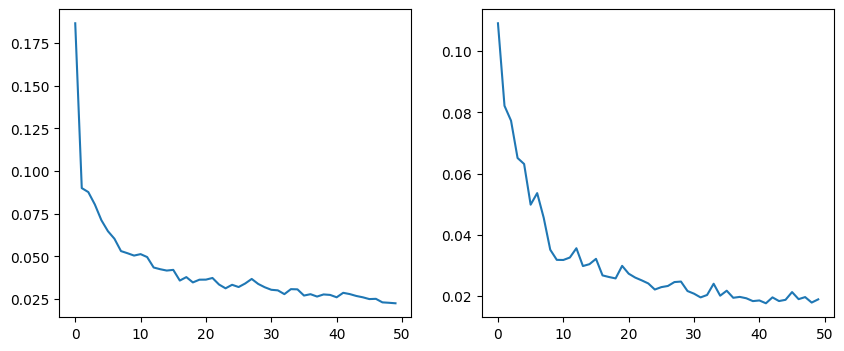

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(train_loss)
ax2.plot(val_loss)

In [4]:
# torch.save(model.state_dict(), f'{os.getcwd()}/models/unet_model.pth')
model_trained = UNet(1, 64, 2)
model_trained.load_state_dict(torch.load(f'{os.getcwd()}/models/unet_model.pth'))
model = model_trained

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# imgs_val, masks_val = next(iter(val_loader1))
# imgs_val = imgs_val.to(device, dtype=torch.float32)
# model = model.to(device)
# model.eval()
# with torch.no_grad():
#     scores = model(imgs_val)
#     preds = torch.argmax(scores, dim=1).float()

# imgs_val = imgs_val.cpu()
# preds = preds.cpu()

# plot_mini_batch(imgs_val.squeeze(1), preds)

### Test

In [6]:
final_imgs = torch.zeros((len(Test1), 432, 512))
final_pred = torch.zeros((len(Test1), 432, 512))
model = model.to(device)
model.eval()
for i,imgs_test in enumerate(test_loader1):
    imgs_test = imgs_test.to(device, dtype=torch.float32)

    with torch.no_grad():
        scores = model(imgs_test)
        preds = torch.argmax(scores, dim=1).float()

    for j in range(len(preds)):
        final_imgs[i*batch_size+j,:,:] = imgs_test[j]
        final_pred[i*batch_size+j,:,:] = preds[j]

final_imgs = final_imgs.cpu()
final_pred = final_pred.cpu()

In [7]:
last = post_processing(final_pred, binary=False)

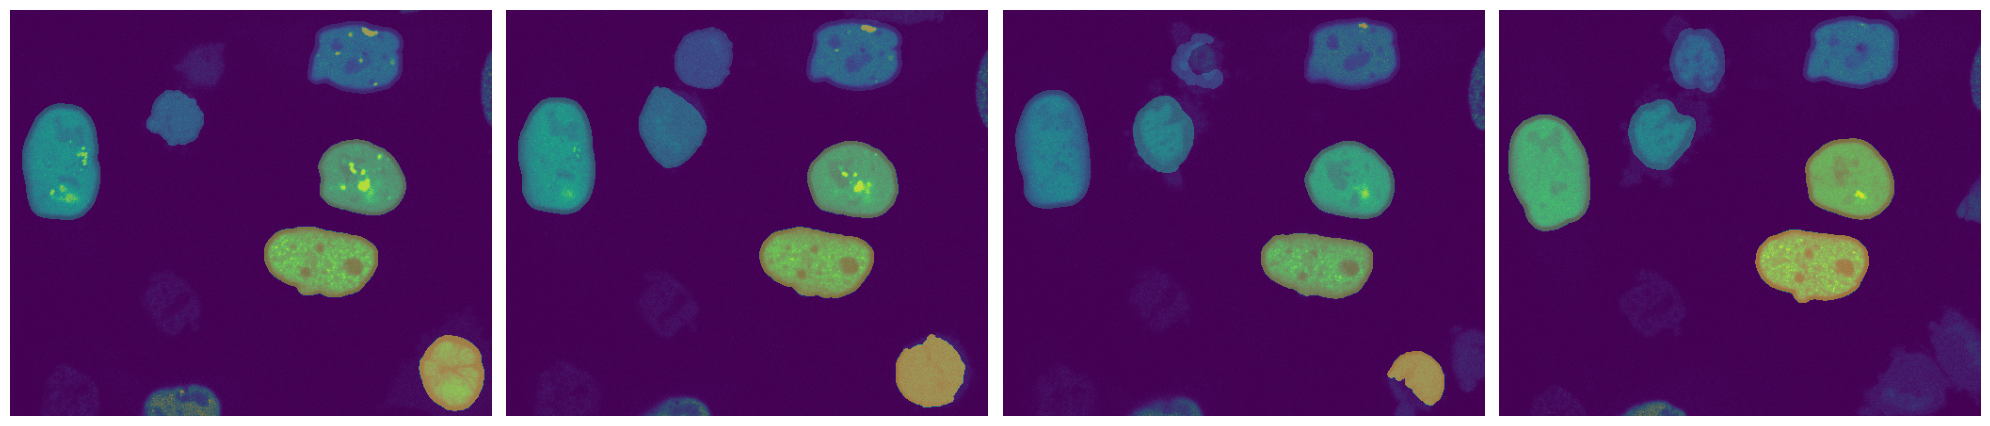

In [8]:
plot_mini_batch(final_imgs[:4], last[:4])

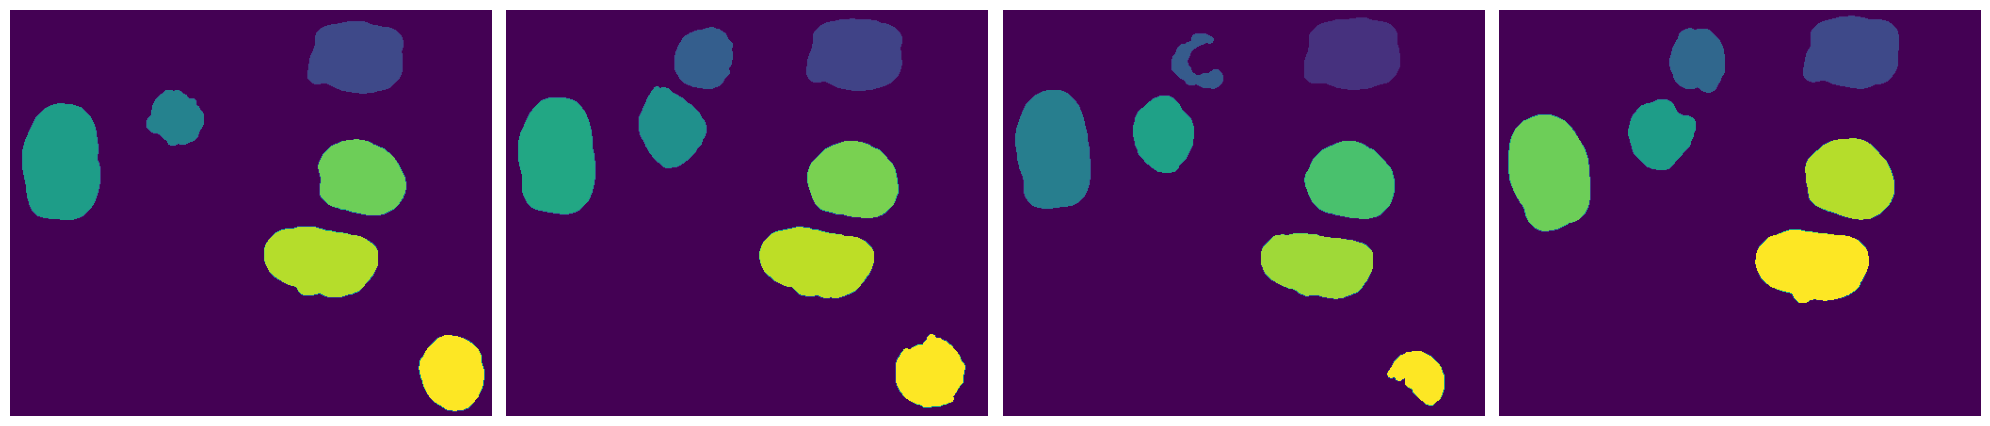

In [9]:
plot_mini_batch(last[:4])